# Computer Vision - Assignment 2 - Deep Learning for Computer Vision

#### 10 points   |   Due date: March 24, 23:59   |   Submission site: https://pradoposgrado2324.ugr.es/

### Student's Full Name: <mark>Seyedeh Kimia Arfaie Oghani</mark>

The goal of this assignment is to learn how to implement and use Convolutional Neural Networks using the fastai library (https://docs.fast.ai/).

In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

In [ ]:
# Function to display evaluation metrics

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()



---



---



---



# <font color='blue'>**Exercise  3: Model transfer and fine-tuning with ResNet18 for the Caltech-UCSD Birds-200-2011 database (3.5 points)**
<font color='blue'>In this exercise we will work with the Caltech-UCSD Birds-200-2011 dataset (https://www.vision.caltech.edu/datasets/cub_200_2011/). This dataset consists of 11,788 images of 200 bird species. It has 200 classes, with 5,994 for training and 5,794 for testing. Again, 10% of the training set will be left for validation. Read the dataset using the provided functions.

<font color='blue'>We will use the ResNet18 network model already pre-trained with ImageNet, it can be downloaded from the fastai Model repository. You have to compare the performance of the following models and training strategies:

<font color='blue'>1. Use ResNet18 as a feature extractor for the Caltech-UCSD Birds-200-2011 dataset under three different scenarios:

>  <font color='blue'>1.1. Remove the final fully-connected (FC) layer of ResNet18, replace it by a FC layer of the dimensionality of the new problem, and train the new weights of this FC layer (while keeping frozen the remaining weights in the network).

> <font color='blue'>1.2. Instead of a single FC layer, employ the head introduced by default in fastai (see https://wandb.ai/capecape/imagenette_timm/reports/Checking-Out-the-New-fastai-timm-Integration--VmlldzoxOTMzNzMw and https://docs.fast.ai/vision.learner.html#head-and-model). Train these new weights (while keeping frozen the remaining weights in the network).

> <font color='blue'>1.3. Create your own head, combining all types of blocks you want (convolutional, FC layers,...). Train all these new weights (while keeping frozen the remaining weight in the network).

<font color='blue'>2. Make a fine-tuning of the entire ResNet18 network. Remember that the number of epochs for fine-tuning must be small.

<font color='blue'>3. Train from scratch the entire ResNet18 network. Remember that the number of epochs must be very small.

<font color='blue'>In each section **it is essential to clearly highlight what exact architecture is being used, as well as what weights are being trained and which are being frozen**. In this sense, a `summary()` must be made to show each of the final architectures used.





---



---



---

First, we need to read the data from the URL

In [ ]:
# https://docs.fast.ai/data.external.html
path = untar_data(URLs.CUB_200_2011)

In [ ]:
print(path)
print(path.ls())
print((path/'CUB_200_2011/').ls())
train_test_split = np.loadtxt('/root/.fastai/data/CUB_200_2011/CUB_200_2011/train_test_split.txt',dtype=int)
# !cat /root/.fastai/data/CUB_200_2011/CUB_200_2011/train_test_split.txt

print('Number of testing examples: ', (train_test_split[:,1]== 0).sum())
print('Number of training examples: ', (train_test_split[:,1]== 1).sum())
print(train_test_split)


/root/.fastai/data/CUB_200_2011
[Path('/root/.fastai/data/CUB_200_2011/attributes.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011')]
[Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/parts'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/classes.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/README'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/attributes'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/bounding_boxes.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/image_class_labels.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/train_test_split.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images.txt')]
Number of testing examples:  5794
Number of training examples:  5994
[[    1     0]
 [    2     1]
 [    3     0]
 ...
 [11786     0]
 [11787     1]
 [11788     0]]


In [ ]:
with open('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images.txt') as file:
    images_list = file.readlines()
    images_list = [line.rstrip() for line in images_list]
print(images_list)

['1 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg', '2 001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg', '3 001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg', '4 001.Black_footed_Albatross/Black_Footed_Albatross_0074_59.jpg', '5 001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.jpg', '6 001.Black_footed_Albatross/Black_Footed_Albatross_0085_92.jpg', '7 001.Black_footed_Albatross/Black_Footed_Albatross_0031_100.jpg', '8 001.Black_footed_Albatross/Black_Footed_Albatross_0051_796103.jpg', '9 001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg', '10 001.Black_footed_Albatross/Black_Footed_Albatross_0025_796057.jpg', '11 001.Black_footed_Albatross/Black_Footed_Albatross_0023_796059.jpg', '12 001.Black_footed_Albatross/Black_Footed_Albatross_0086_796062.jpg', '13 001.Black_footed_Albatross/Black_Footed_Albatross_0049_796063.jpg', '14 001.Black_footed_Albatross/Black_Footed_Albatross_0006_796065.jpg', '15 001.Black_footed_Albatr

In [ ]:
classes = (path/'CUB_200_2011/images/').ls()
print('Number of examples per class')
for i in range(len(classes)):
  print(len(classes[i].ls()), end=" ")


Number of examples per class
60 60 60 60 59 59 60 59 60 60 60 60 60 60 60 60 60 60 60 60 60 60 59 50 60 60 60 60 60 60 60 60 60 59 60 60 60 60 60 58 60 60 60 60 60 60 60 60 60 59 60 60 60 59 52 59 53 60 60 45 60 59 58 60 60 60 60 60 58 60 60 60 57 60 60 60 56 60 60 60 59 59 60 60 60 60 60 59 60 60 60 59 60 60 60 60 59 60 60 59 60 60 44 59 59 60 60 60 53 60 60 60 60 60 60 58 60 59 59 60 60 60 50 60 60 41 60 58 60 60 58 60 60 60 59 60 50 60 60 60 59 60 60 60 60 60 60 60 60 60 60 60 60 60 50 60 60 60 60 60 59 60 60 60 60 60 48 60 59 59 60 60 59 60 60 59 60 53 60 60 60 49 59 60 60 59 59 57 60 60 60 56 60 60 60 56 59 51 59 60 

In [ ]:
# Now we have in images_list the list with all the images, and in train_test_split which ones belong to training (1) or test (0)
# We are going to create two folders: one train and another test, and we are going to put the corresponding images inside
print(path)
import shutil, os
if os.path.isdir('/root/.fastai/data/CUB_200_2011/train'):
  shutil.rmtree('/root/.fastai/data/CUB_200_2011/train')
if os.path.isdir('/root/.fastai/data/CUB_200_2011/test'):
  shutil.rmtree('/root/.fastai/data/CUB_200_2011/test')

shutil.copytree('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images','/root/.fastai/data/CUB_200_2011/train')
shutil.copytree('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images','/root/.fastai/data/CUB_200_2011/test')


/root/.fastai/data/CUB_200_2011


'/root/.fastai/data/CUB_200_2011/test'

In [ ]:
print((path/'train').ls())
print(len((path/'train').ls()))

[Path('/root/.fastai/data/CUB_200_2011/train/035.Purple_Finch'), Path('/root/.fastai/data/CUB_200_2011/train/027.Shiny_Cowbird'), Path('/root/.fastai/data/CUB_200_2011/train/044.Frigatebird'), Path('/root/.fastai/data/CUB_200_2011/train/147.Least_Tern'), Path('/root/.fastai/data/CUB_200_2011/train/039.Least_Flycatcher'), Path('/root/.fastai/data/CUB_200_2011/train/149.Brown_Thrasher'), Path('/root/.fastai/data/CUB_200_2011/train/099.Ovenbird'), Path('/root/.fastai/data/CUB_200_2011/train/126.Nelson_Sharp_tailed_Sparrow'), Path('/root/.fastai/data/CUB_200_2011/train/189.Red_bellied_Woodpecker'), Path('/root/.fastai/data/CUB_200_2011/train/093.Clark_Nutcracker'), Path('/root/.fastai/data/CUB_200_2011/train/123.Henslow_Sparrow'), Path('/root/.fastai/data/CUB_200_2011/train/068.Ruby_throated_Hummingbird'), Path('/root/.fastai/data/CUB_200_2011/train/062.Herring_Gull'), Path('/root/.fastai/data/CUB_200_2011/train/194.Cactus_Wren'), Path('/root/.fastai/data/CUB_200_2011/train/197.Marsh_Wren'

In [ ]:
import os
for i in range(len(train_test_split)):
    if train_test_split[i,1]==0: #test image
       os.remove(path/'train'/images_list[i].rsplit(' ')[1]) #we remove it from train
    if train_test_split[i,1]==1: #train image
      os.remove(path/'test'/images_list[i].rsplit(' ')[1]) #we remove it from test

In [ ]:
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))


Total training images:  5994
Total test images:  5794


In [ ]:
print(f"Dataset path set to: {path}")
print(f"Files found: {len(get_image_files(path))} images")

Dataset path set to: /root/.fastai/data/CUB_200_2011
Files found: 23576 images


**1. Creating the datablock.**

First, let's create the dataloader object. valid_pct is 0.1 as 10% of the training data is in the validation set. Upon creating this dataloader, I realized that images in the Caltech-UCSD dataset have different sizes; therefore, I chose to resize all the images to 224, which is the size of images in ImageNet, which resnet18 is pretrained on.

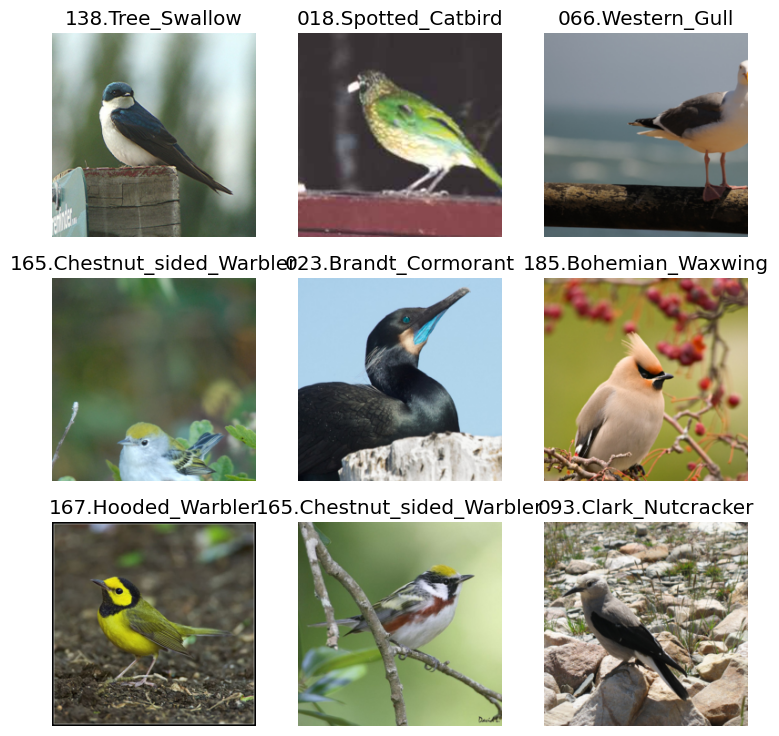

In [ ]:
# Creating the DataBlock
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Specify data types
    get_items=get_image_files,  # Collect data items
    splitter=RandomSplitter(valid_pct=0.1,seed=42),  # 10% is for validation set
    get_y=parent_label,  # Label items based on folder names
    item_tfms=Resize(224) # Resizing to the size that resnet18 was trained on
)

dls = db.dataloaders(path, bs=32) # Creating the Dataloader

# Show a batch from the training set
dls.show_batch(max_n=9)

**2. Load the existing model with pre-trained weights**

In this exercise we are loading the ResNet18 model.

ResNet18 is a variant of the ResNet model with 18 layers, widely used for image classification tasks due to its efficiency and performance.

ResNet uses Skip connections/Residual connections, to avoid loss of information flow.

One issue ResNets address is the vanishing gradient problem. This occurs when the network depth causes gradients to quickly shrink to zero as they are going back through the network due to repeated application of the chain rule. Consequently, the weights remain unchanged, therefore, negatively affecting the learning. In these networks, the gradient flows from very deep layers to the input, through skip connections.

A Skip/Residual connection bypasses the nᵗʰ convolution layer by adding the activations from the (n-1)ᵗʰ convolution layer directly to the output of the (n+1)ᵗʰ layer. It then applies a ReLU function to this combined result, effectively "skipping" the intermediate layer.



**Identifying the dimensions of the new problem**

In order to later in the following section, identify the dimensionality of the new problem, we should realize that since we are removing the last FC layer of ResNet18; when we add the new FC layer, the new FC layer should connect the m units to n units, in which n is the 200 classes in our dataset, and m is the number of input features in the last FC layer of ResNet that we want to delete (which now is our new number of input features).
Therefore, in order to identify this m, the following code has been implemented.
We see that the number of input features to the last FC layer in ResNet18 is 512. Therefore, later when we are defining the new FC layer, this layer should connect 512 units to 200.

In [ ]:
# Identifying the dimension of the new problem
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
print(num_features)

512


## <font color='blue'> 3.1.1 Train single FC layer included in the head

**1. Select the model and Create the Custom Head**

Now, we have to define the new FC layer, suitable for our problem; in order to add it to the network, after removing the last FC layer of the ResNet18.

To define this new FC layer, we create a custom_head to pass to the custom_head in the vision_learner function, to modify the last layer.

First, in this custom_head, we have AdaptiveAvgPool2d((1,1)); this operation reduces the dimension as it adapts the input size to a fixed output size, here (1,1), essentially performing average pooling. Regardless of the size of the input feature maps, adaptive average pooling produces a fixed-size output (in this case, 1x1 per feature map), which is crucial for connecting to fully connected layers.

Adaptive Average Pooling is a pooling operation designed to output feature maps of a specified size. What makes this "adaptive" is its ability to adjust the pooling operation to any input size to achieve the desired output size. Here, with size of 1x1, the operation calculates the average of all values in each feature map, effectively condensing the entire spatial information of each feature map into a single value.

Then, we have flatten; after pooling, we have a batch of 1x1 feature maps, one for each filter in the preceding layer (512 in our case). However, before we can feed this into a fully connected layer, we need to convert the batch of 1x1x512 feature maps into a batch of vectors (of length 512).

We have to keep in mind, that when we use vision_learner, Fastai removes the last fully-connected automatically and introduces other layers with dimensions adapted to the problem represented by dls. Therefore, this part automatically happens and we don't need to do anything to remove the last FC layer.

Next, we use vision_learner to create the learner object with vision_learner.

We also should take into account that BatchNormalization parameters are always adapted by default; so, in this case, when we don't want to adapt them, we use "train_bn=False" inside the Learner definition.

As it can be seen in the summary of the learner object, now, all the layers, including the BN ones, have "trainable" as false, except the last FC layer which we added to the network; meaning that they won't be updated in the training procedure next.

**Note**

Regarding the loss function for training (usually defined when creating the learner object): I didn't specify any loss function in the vision_learner function in this section; if no loss function is specified, the default loss function for the data loaders object is used. The dataloader object selects an appropriate loss function based on the type of the target. Here, since we have used a CategoryBlock for our target variable (it's a classification problem), CrossEntropyLoss is added as the default loss function by Fastai.

In [ ]:
# 3.1.1.1

# Select the model and Create the Custom Head
model = fastai.vision.models.resnet18

custom_head = nn.Sequential(
    nn.AdaptiveAvgPool2d((1,1)), # Adaptive Average Pooling
    nn.Flatten(),
    nn.Linear(512, 200) # FC layer
)

# Replacing the FC Layer and Creating the learner object

dls = db.dataloaders(path, bs=32) #Loading the dataset

# Creating the learner
custom_leaner = vision_learner(deepcopy(dls), model, custom_head=custom_head, metrics=[accuracy,error_rate], pretrained=True, train_bn=False)
custom_leaner.summary()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        False     
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
ReLU                      

**2. Training the network**

Here, the objective is to freeze all the layers before the last FC layers. Freezing is a technique used to selectively train certain parts of a neural network while keeping others unchanged. Therefore, here we don't want to change the weights in the pretrained layers, as we only want the network to learn the weights for the newly added FC layer and use the pretrained weights of resnet18 for the previous ones.

First, we use learn.freeze(), this function freezes all the layers up to the last parameter group, therefore the entire network will be frozen except the newly added FC layer. This step is crucial for transfer learning (Taking a pretrained network and transfer that knowledge to a new task), allowing the model to adjust the new weights without disturbing the pre-trained ones significantly.

Next, we want to train ONLY the last FC layer, while all the other layers are still frozen. Therefore, we can again use the learn.fit_one_cycle(), as explained in the last part of the assignment 2. There is no need to unfreeze all layers before going to training, as it is not what we are looking for here.

0.0010000000474974513


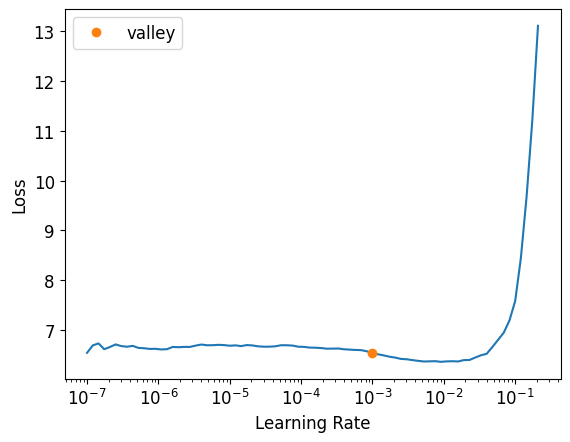

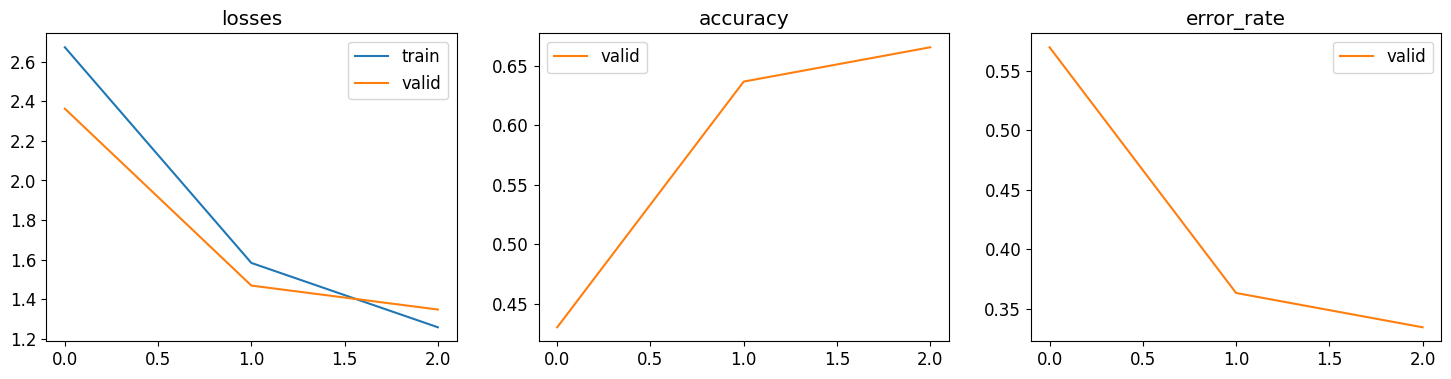

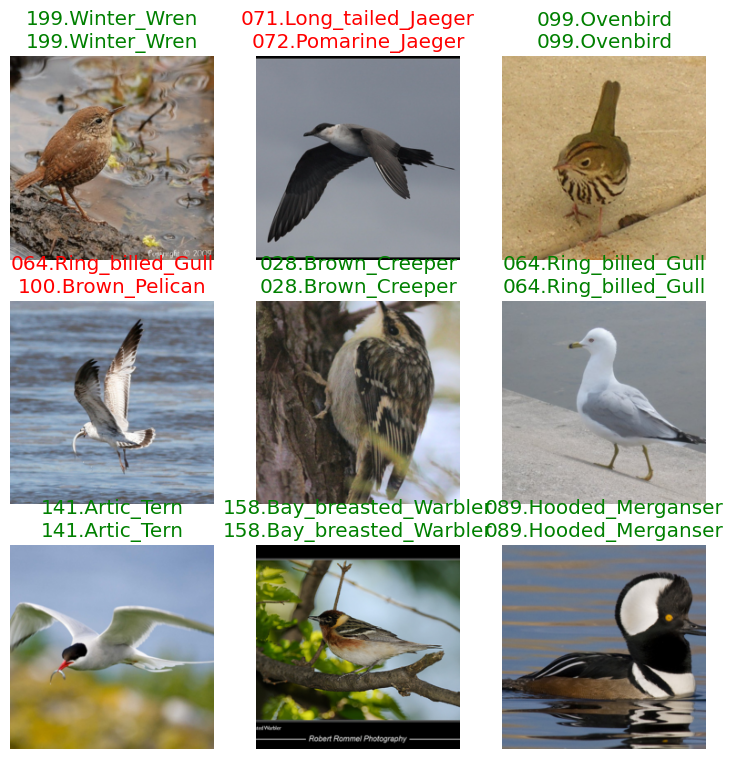

In [ ]:
# 3.1.1.2

# Making sure all the layers before the last FC layer is frozen
custom_leaner.freeze()

c_lr=custom_leaner.lr_find() # find the maximum value for lr to use in the next call to the optimizer
print(c_lr[0])

custom_leaner.fit_one_cycle(n_epoch=3, lr_max=c_lr[0]) # running the optimizer one-cycle

# Evaluating the model
custom_leaner.recorder.plot_metrics() # Shows accuracy curve along epochs

custom_leaner.show_results()

**3. Testing the model and compute the accuracy of the test**

In [ ]:
test_dl = custom_leaner.dls.test_dl(files_test,with_labels=True)

preds, targs = custom_leaner.get_preds(dl=test_dl)

# We compute accuracy
acc1 = accuracy(preds, targs)
print('The test accuracy is : ', round(float(acc1)*100, 4), '%')

The test accuracy is :  75.0259 %


**3.1.1 Discussion**

We see that with a simple FC layer added to the ResNet18 which was suitable for the dimention of our problem (output of 200 units for the 200 classes in the dataset), while only learning the new layer and previous layers as frozen, the validation accuracy reaches to around 65% within just 3 epochs. Both test and validation losses are constantly decreasing indicating that the network is learning effectively.

The network was also tested on the test dataset, and the test accuracy was around 75%, indicating that the network is being generalized well for unseen data, and the network is effective for our task.

However, there is room for more improvement and increasing the accuracy, which we can see in the next sections.

## <font color='blue'> 3.1.2 Train head included by default in fastai

**1. Select the model and Create the Custom Head**

In this section, we want to delete the last FC layer in Resnet18 again and use the default head that Fastai uses to add to the network. When we use "vision_learner" and do not specify a custom_head, FastAI automatically appends a default head to the pre-trained backbone (ResNet18) by calling the create_vision_model, which stacks this head on top of the network.

Looking at the summary for the learner object in the following section, we see that the custom head added is as follows:

AdaptiveAvgPool2d((1,1)), AdaptiveMaxPool2d((1,1)), Flatten(), BatchNorm1d(), Droppout(), Linear (FC layer), ReLU, BatchNorm1d, Dropout, Linear (FC layer).

This custom head combines both adaptive average pooling and adaptive max pooling layers, concatenates their results (512 + 512 = 1024), and then follows up with a sequence of layers including flattening, batch normalization, dropout, linear layers (going from 1024 to 512 to 200), and ReLU activations. This design aims to extract and combine a wide range of features before the final classification layer that outputs 200 classes, which is way more sophisticated than the custom head we added in the previous section.

In [ ]:
# 3.1.2.1

model = fastai.vision.models.resnet18

dls = db.dataloaders(path, bs=32) #Loading the dataset

# Create the learner object, using the default head of fastai

custom_leaner2 = vision_learner(deepcopy(dls), model, metrics=[accuracy,error_rate], pretrained=True, train_bn=False)

custom_leaner2.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        False     
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
ReLU                      

**2. Train the model**

Here, we continue to first freeze all the pretrained layers, as we did before in the previous section, and train the model.

0.001737800776027143


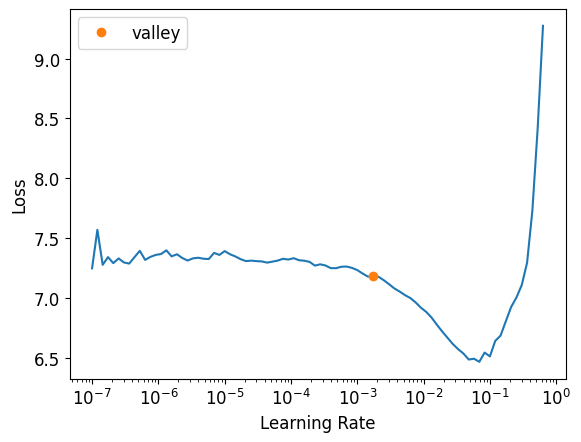

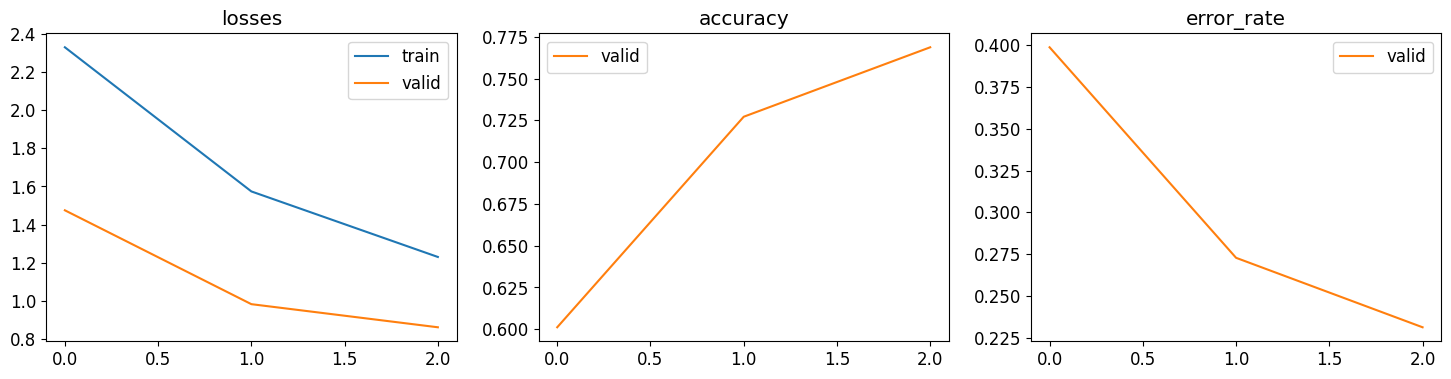

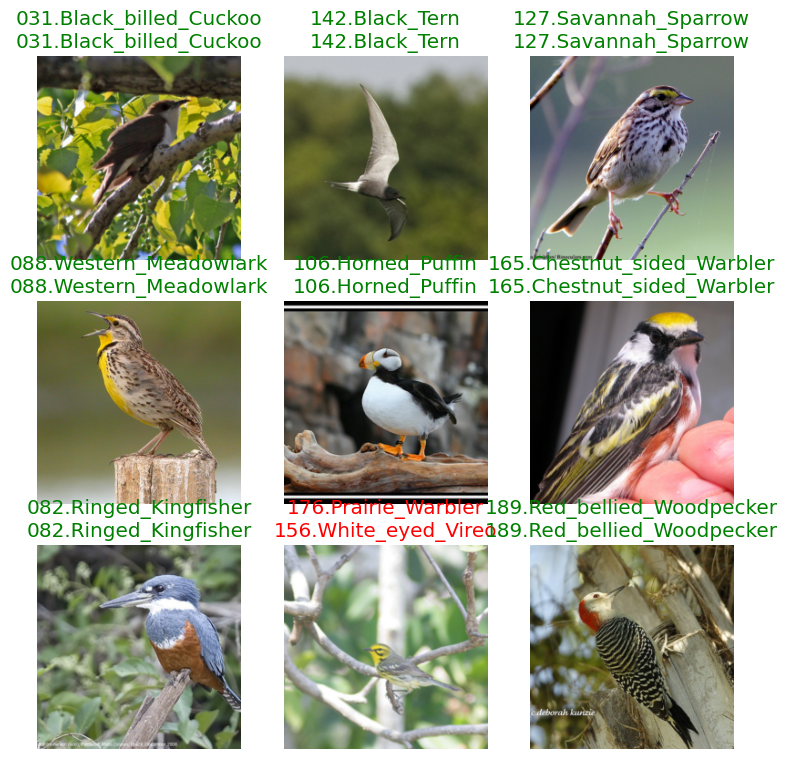

In [ ]:
# 3.1.2.2

# Making sure all the layers are frozen except the new added head
custom_leaner2.freeze()

c_lr2 = custom_leaner2.lr_find() # find the maximum value for lr to use in the next call to the optimizer
print(c_lr2[0])

custom_leaner2.fit_one_cycle(n_epoch=3, lr_max=c_lr2[0]) # running the optimizer one-cycle

# Evaluating the model
custom_leaner2.recorder.plot_metrics() # Shows accuracy curve along epochs

custom_leaner2.show_results()

**3. Test the model and compute the test accuracy**

In [ ]:
test_dl = custom_leaner2.dls.test_dl(files_test,with_labels=True)

preds, targs = custom_leaner2.get_preds(dl=test_dl)

# We compute accuracy
acc1 = accuracy(preds, targs)
print('The test accuracy is : ', round(float(acc1)*100, 4), '%')

The test accuracy is :  86.5723 %


**3.1.2 Discussion**

We see that when we used the Fastai default head added to the ResNet18, the validation accuracy is around 77% which is increased compared to the previous section.

The network was also tested on the test dataset, and the test accuracy was around 86%, again more than the test accuracy in the previous section, indicating that the network is being generalized well for unseen data, and the network is now way more effective for our task.

By comparing this (using the default custom head) to the previous section (using only a single FC layer as the custom head), we can indicate that now the complexity of the model has increased in complexity, which allows the model to learn more features within the data, improving its performance.

## <font color='blue'> 3.1.3. Train new custom head (including convolutional layers, FC layers, etc.)

**1. Create the custom head**

In the following section, I chose to add more convolution layers along with BN and ReLU layers, to make the model more complex, even than the previous section. We know that having more convolutional layers and filters will increase the depth and capacity of the network, which will increase the ability of it to learn more complex features of the data. Also, I chose to use 1x1 and 3x3 kernels, which are more computationally efficient, and also increase non-linearity.

The new custom head:

First, I added 1x1 convolution layer, which takes in 512 as input channel (which we know is the output channel of the network for the last layer), and 550 as the output channel.

Second, we have two back to back 3x3 kernels, first getting 550 as input channel and 600 as output, the next one, having 600 as the input channel and 650 as the output.

Last, we have adaptive average pooling with size 1x1, before flattening and a single FC layer.

In [ ]:
#3.1.3.1

# Select the model and Create the Custom Head
model = fastai.vision.models.resnet18

# Create the new custom head
custom_head2 = nn.Sequential(
    nn.Conv2d(512, 550, kernel_size = (1,1), stride=1), # Conv layer to process features
    nn.BatchNorm2d(550),  # Correct BatchNorm to match conv output channels
    nn.ReLU(),

    nn.Conv2d(550, 600, kernel_size = (3,3), padding=0, stride=1),
    nn.BatchNorm2d(600),  # Correct BatchNorm to match conv output channels
    nn.ReLU(),

    nn.Conv2d(600, 650, kernel_size = (3,3), padding=0, stride=1),
    nn.BatchNorm2d(650),  # Correct BatchNorm to match conv output channels
    nn.ReLU(),

    nn.AdaptiveAvgPool2d((1,1)),

    nn.Flatten(),                       # Flatten the output for the FC layer

    nn.Linear(650, 200)                 # Fully connected layer to 200 classes
)


**2. Create learner object**

The functions are as before, with train_bn=False.

In [ ]:
#3.1.3.2

# Creating the learner object
dls = db.dataloaders(path, bs=32) #Loading the dataset

custom_leaner3 = vision_learner(deepcopy(dls), model, custom_head=custom_head2, metrics=[accuracy,error_rate], pretrained=True, train_bn=False)
custom_leaner3.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        False     
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
ReLU                      

**4. Train the model**

0.0010000000474974513


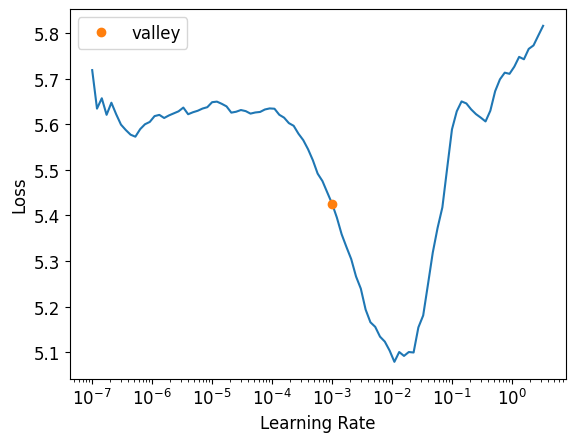

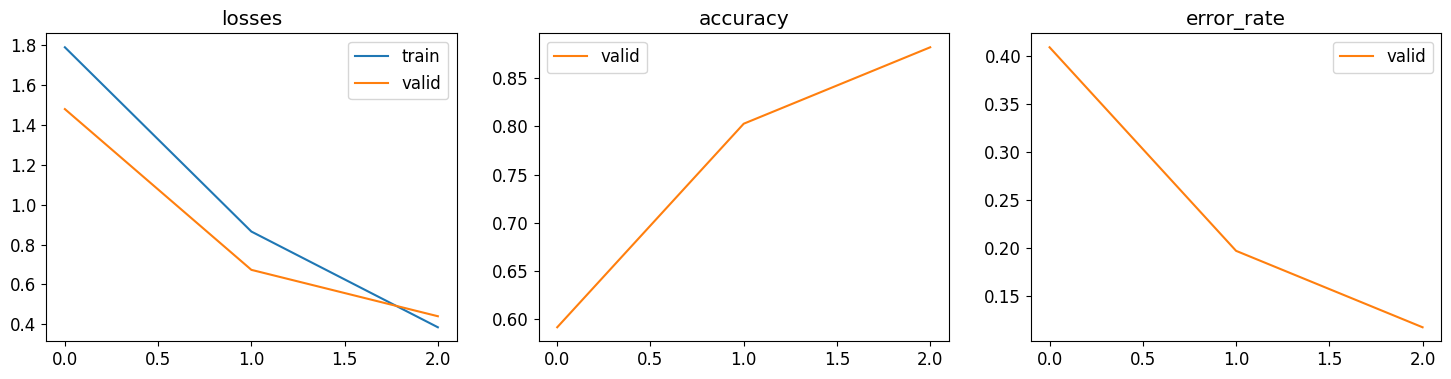

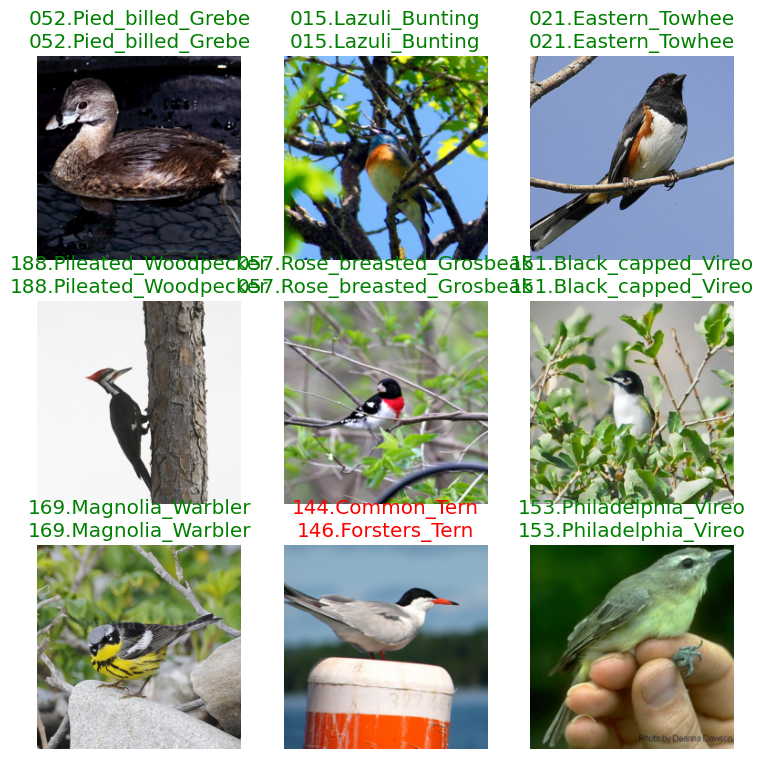

In [ ]:
#3.1.3.3

# Making sure layers before the custom head are frozen
custom_leaner3.freeze()

c_lr3=custom_leaner3.lr_find() # find the maximum value for lr to use in the next call to the optimizer
print(c_lr3[0])

custom_leaner3.fit_one_cycle(n_epoch=3, lr_max=c_lr3[0]) # running the optimizer one-cycle

# Evaluating the model
custom_leaner3.recorder.plot_metrics() # Shows accuracy curve along epochs

custom_leaner3.show_results()

**5. Test the network and compute test accuracy**

In [ ]:
test_dl = custom_leaner3.dls.test_dl(files_test,with_labels=True)

preds, targs = custom_leaner3.get_preds(dl=test_dl)

# We compute accuracy
acc1 = accuracy(preds, targs)
print('The test accuracy is : ', round(float(acc1)*100, 4), '%')

The test accuracy is :  96.1857 %


**3.1.3 Discussion**

We see that when we use this new custom head added to the ResNet18, the validation accuracy is now around 85% which is increased compared to the previous sections. Loss curves are both decreasing; we can also see that the train loss and validation loss are much closer to each other now, which was not the case with the previous section, which was a bit concerning.

The network was also tested on the test dataset, and the test accuracy was around 96%, again more than the test accuracy in the previous section.

Comparing this network, with previous sections, the performance has improved a lot, indicating enhanced feature processing due to the complexity and capacity of the new network, making this network very effective for classification of the dataset.

## <font color='blue'> 3.2. Fine-tuning of all ResNet18 (including the suitable FC layer as output/head)

**1. Create the network**

In this section we will be fine-tuning all of the ResNet18 with the custom head, which I created in the 3.1.3 section. In general, we can define fine-tuning as taking a pre-trained model, which has been trained on a large dataset, and making adjustments to its parameters. In this section, we do this by first, only training the new head while previous layers are frozen for one epoch, then we will train the whole model for three epochs while all the layers are not frozen anymore.

In [ ]:
#3.2.1

model = fastai.vision.models.resnet18

# Replacing the FC Layer with custom head

dls = db.dataloaders(path, bs=32) #Loading the dataset

custom_leaner5 = vision_learner(deepcopy(dls), model, custom_head=custom_head2, metrics=[accuracy,error_rate], pretrained=True, train_bn=False)
custom_leaner5.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        False     
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
ReLU                      

**2. Create lerner object and train the network**

In this part, to fine-tune the network, I will use the learner.fine_tune() function. This function trains the added layers (my custom head) for specific epochs (by default, freeze_epochs=1), with all other layers “frozen”. Then, it “Unfreezes” all layers, and trains them for the indicated number of epochs.
This function internally uses fit_one_cycle(), so we know that this method is also benig used here.

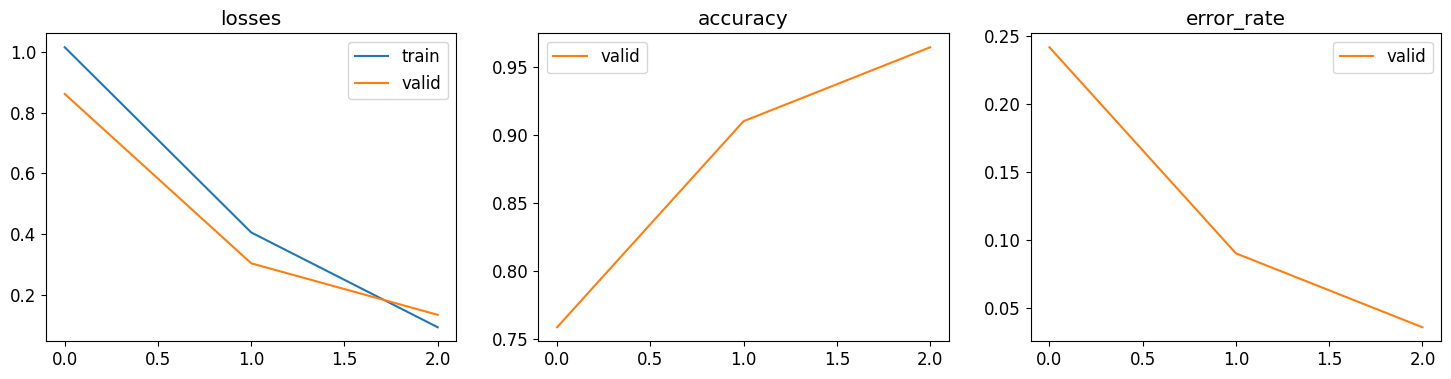

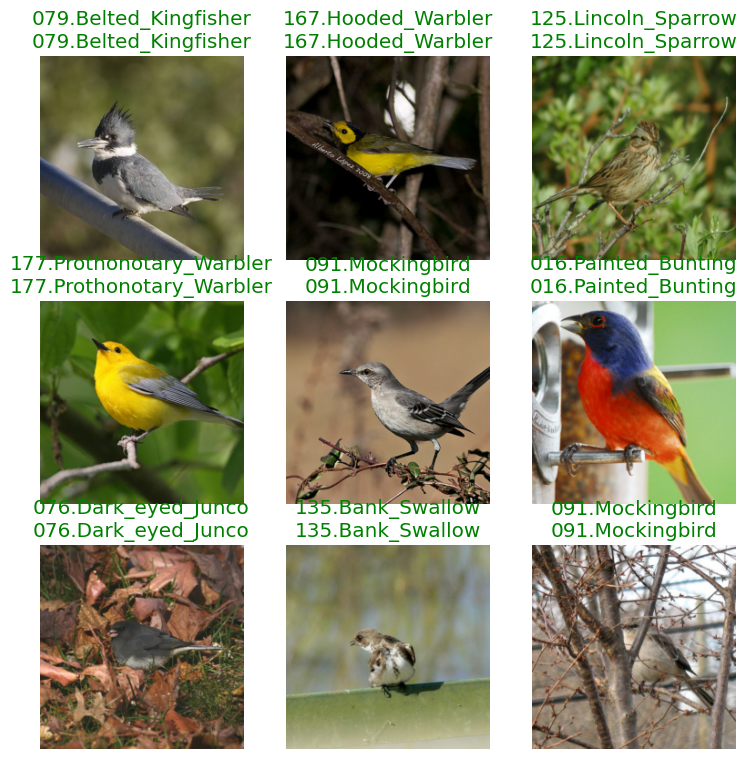

In [ ]:
#3.2.2

custom_leaner5.fine_tune(epochs = 3, freeze_epochs=1)

custom_leaner5.recorder.plot_metrics() # Shows accuracy curve along epochs

custom_leaner5.show_results()

**3. Test the network and calculate test accuracy**

In [ ]:
test_dl = custom_leaner5.dls.test_dl(files_test,with_labels=True)

preds, targs = custom_leaner5.get_preds(dl=test_dl)

# We compute accuracy
acc1 = accuracy(preds, targs)
print('The test accuracy is : ', round(float(acc1)*100, 4), '%')

The test accuracy is :  99.3096 %


**3.2 Discussion**

After this fine-tuning, we see that the validation accuracy is now around 95, and test accuracy around 99%, which is a significant improvement.

Fine-tuning, especially after initially training just the custom head, allows the entire network (both the pre-trained base and the custom head) to adjust to our dataset, which we can see, has led to a significant boost in performance.

## <font color='blue'>  3.3. Train from scratch the entire ResNet18 (including the suitable FC layer as output/head)

**1. Create the learner object**

In this section, since we want to train the network from scratch, we don't want to include the pretrained weights of ResNet18 in the network, therefore "pretrained = False" was included inside the vision_learner function.

In this case, all the weights of the network, both in the base ResNet18 model and in the custom head, will be initialized to random values and then will be learned from the dataset during the training process.

In [ ]:
#3.3.3
model = fastai.vision.models.resnet18

dls = db.dataloaders(path, bs=32)  # Loading the dataset

# Creating the learner object for training from scratch
custom_leaner6 = vision_learner(dls, model, custom_head=custom_head2, metrics=[accuracy, error_rate], pretrained=False)

custom_leaner6.summary()



Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

**2. Train from scratch**

3.0199516913853586e-05


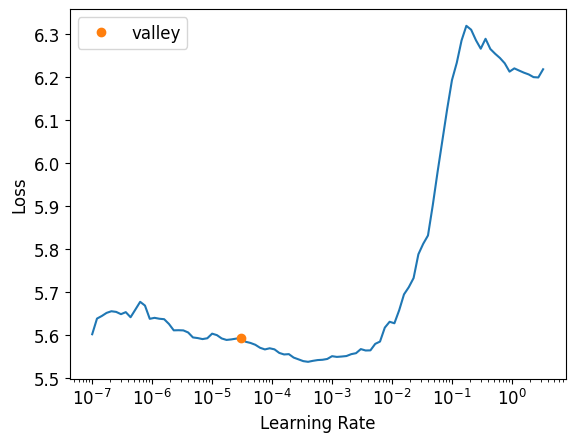

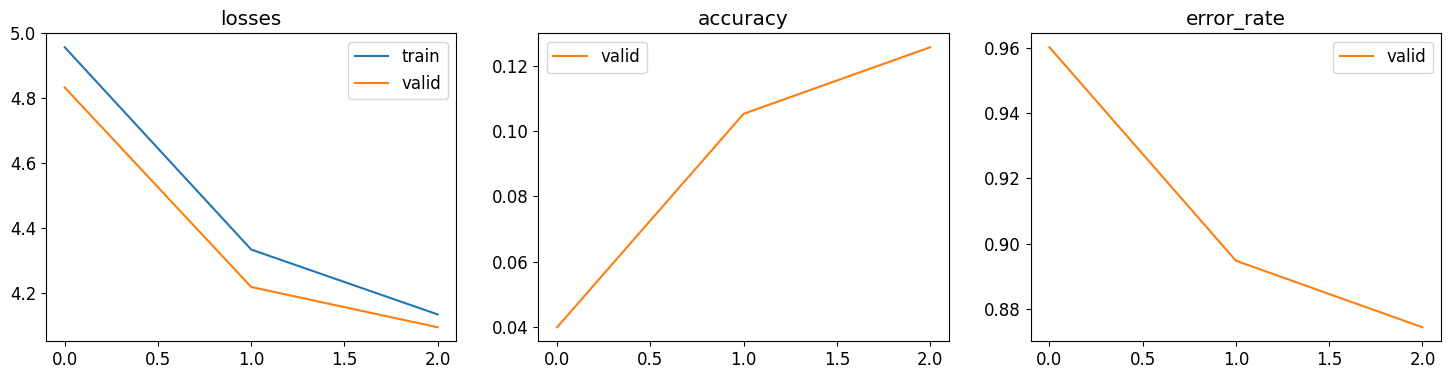

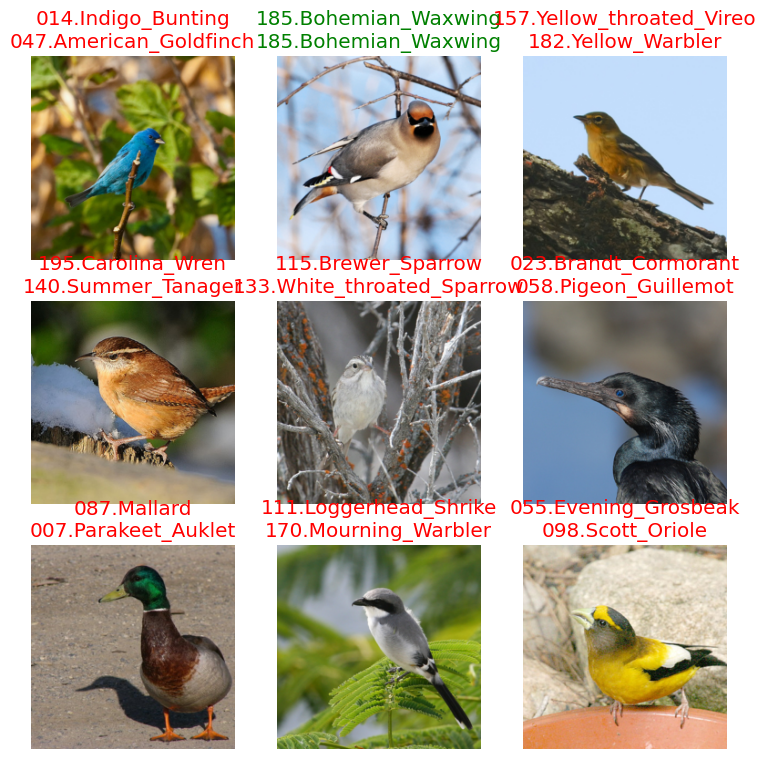

In [ ]:
#3.3.3

# Train the model from scratch

c_lr6=custom_leaner6.lr_find()

print(c_lr6[0])

custom_leaner6.fit_one_cycle(3, lr_max=c_lr6[0])

custom_leaner6.recorder.plot_metrics() # Shows accuracy curve along epochs

custom_leaner6.show_results()

**3. Testing the network**

In [ ]:
test_dl = custom_leaner6.dls.test_dl(files_test,with_labels=True)

preds, targs = custom_leaner6.get_preds(dl=test_dl)

# We compute accuracy
acc1 = accuracy(preds, targs)
print('The test accuracy is : ', round(float(acc1)*100, 4), '%')

The test accuracy is :  16.8278 %


**3.3 Discussion**

By training from scratch it can be seen that both the validation accuracy (around 12%), and test accuracy (around 16%) has decreased significantly compared to previous sections.

We can say that training from scratch poses new challenges compared to fine-tuning a pre-trained model.

The model is learning, as evidenced by the decreasing loss and error rate, along with increasing accuracy, although the changes are really small.
We can say, that the model has not yet had enough time (epochs) to sufficiently learn from the data.
The low accuracy indicates that the model is not yet fitting the data well.
Since we're training from scratch, the model has to learn all the features without any prior knowledge, which takes longer and can explain the lower accuracy compared to the previous sections.
